In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

https://drive.google.com/file/d/1k2dCiBV-OTK0OSWCagsJPwbEytDky1sM/view?usp=sharing

In [2]:
! gdown --id 1k2dCiBV-OTK0OSWCagsJPwbEytDky1sM

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1k2dCiBV-OTK0OSWCagsJPwbEytDky1sM
From (redirected): https://drive.google.com/uc?id=1k2dCiBV-OTK0OSWCagsJPwbEytDky1sM&confirm=t&uuid=90a458ea-db52-4db4-9359-a4cdf41aa6da
To: /content/vacancies_2024.csv
100% 1.29G/1.29G [00:11<00:00, 110MB/s] 


In [3]:
from IPython.display import display

df = pd.read_csv("/content/vacancies_2024.csv", parse_dates=['published_at'])
df.head()

<ipython-input-3-6537834bfa31>:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/vacancies_2024.csv", parse_dates=['published_at'])


,name,key_skills,salary_from,salary_to,salary_currency,area_name,published_at
0,SAP R/3 functional consultant,NaN,NaN,NaN,NaN,Москва,2003-01-24 21:30:49+03:00
1,Broadcast encryption engineer,NaN,NaN,2000.0,USD,Южная Корея,2003-01-31 18:24:11+03:00
2,Embedded OS engineering manager,NaN,NaN,2000.0,USD,Москва,2003-01-31 18:25:43+03:00
3,Coordinator on Intellectual Property Projects,NaN,NaN,NaN,NaN,Москва,2003-02-12 10:40:50+03:00
4,Outsourcing Projects Coordinator,NaN,NaN,NaN,NaN,Москва,2003-02-14 16:31:06+03:00


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6915297 entries, 0 to 6915296
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   name             object 
 1   key_skills       object 
 2   salary_from      float64
 3   salary_to        float64
 4   salary_currency  object 
 5   area_name        object 
 6   published_at     object 
dtypes: float64(2), object(5)
memory usage: 369.3+ MB


# Общая статистика

In [5]:
import requests
import pandas as pd
import xml.etree.ElementTree as ET

def get_all_currency():
    """
    Получает курсы валют из Центрального банка России (ЦБР) за период с января 2003 года по декабрь 2024 года.

    Функция отправляет HTTP-запросы к API ЦБР для получения данных о курсах валют и сохраняет их в словаре.
    Курс валюты сохраняется в формате:
    {
        'YYYY-MM': {
            'BYR': курс,
            'USD': курс,
            'EUR': курс,
            ...
        },
        ...
    }

    Returns:
        dict: Словарь с курсами валют, где ключами являются строки формата 'YYYY-MM',
              а значениями — словари с курсами валют.
    """
    month = 1
    year = 2003
    all_currency = 'BYR,USD,EUR,KZT,UAH,AZN,KGS,UZS,GEL'.split(',')
    len_cur = len(all_currency)
    result = {}
    while True:
        if year == 2024 and month == 12:
            break
        month_str = str(month)
        # print(f'{year}-{month_str}')
        if month < 10:
            month_str = '0' + month_str
        try:
          response = requests.get(f'https://cbr.ru/scripts/XML_daily.asp?date_req=01/{month_str}/{year}')
          result[f'{year}-{month_str}'] = {}
          root = ET.fromstring(response.content)
          for item in root.findall('Valute'):
              name = item.find('CharCode').text
              try:
                  index = all_currency.index(name) + 1
                  result[f'{year}-{month_str}'][name] = float(item.find('VunitRate').text.replace(',', '.'))
              except ValueError:
                  continue
        except Exception:
            continue
        if month == 12:
            month = 1
            year += 1
        else:
            month += 1
    return result

In [6]:
table_curr = get_all_currency()

In [7]:
def avg_salary(row):
  if row['salary_from'] and row['salary_to']:
    res = (row['salary_from'] + row['salary_to']) / 2

  elif row['salary_from']:
    res = row['salary_from']

  elif row['salary_to']:
    res = row['salary_to']
  else:
    return np.nan

  currency = row['salary_currency']
  try:
    if currency != 'RUR' and not pd.isnull(currency) and table_curr[row['data']][currency]:
      salary = table_curr[row['data']][currency] * res
      return salary
  except KeyError:
    return np.nan
  return res

In [8]:
def extract(value):
    data = str(value)[:7]
    return data

In [9]:
def extract_year(value):
    data = str(value)[:4]
    return int(data)

In [10]:
df_full = df.copy()

In [11]:
df_full['data'] = df_full['published_at'].apply(extract)

In [12]:
df_full['avg_salary'] = df_full.apply(avg_salary,axis=1)

In [13]:
df_full = df_full[df_full['avg_salary'] < 10_000_000]
df_full.shape

(1697612, 9)

In [14]:
df_full['year'] = df_full['published_at'].apply(extract_year)

In [15]:
df_full_salary = df_full[["name","avg_salary", "area_name",'year']].copy()

### Динамика уровня зарплат по годам

In [16]:
df_full_salary_pivot = df_full_salary.pivot_table(index='year', values=['avg_salary'])
df_full_salary_pivot = df_full_salary_pivot.reset_index()
df_res = df_full_salary_pivot.copy()

df_res['avg_salary'] = df_res['avg_salary'].astype(int)
df1 = df_res.iloc[len(df_res)//2:][::-1]
df2 = df_res.iloc[:len(df_res)//2][::-1]

df_combined = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)
df_combined.columns = ['year_1', 'avg_salary_1', 'year_2', 'avg_salary_2']
df_combined.set_index('year_1', inplace=True)
df_combined


,avg_salary_1,year_2,avg_salary_2
year_1,,,
2024,109144,2014,49256
2023,97951,2013,52229
2022,93447,2012,48477
2021,86465,2011,47829
2020,75756,2010,45443
2019,72945,2009,45629
2018,69381,2008,48185
2017,63265,2007,45513
2016,57911,2006,41840


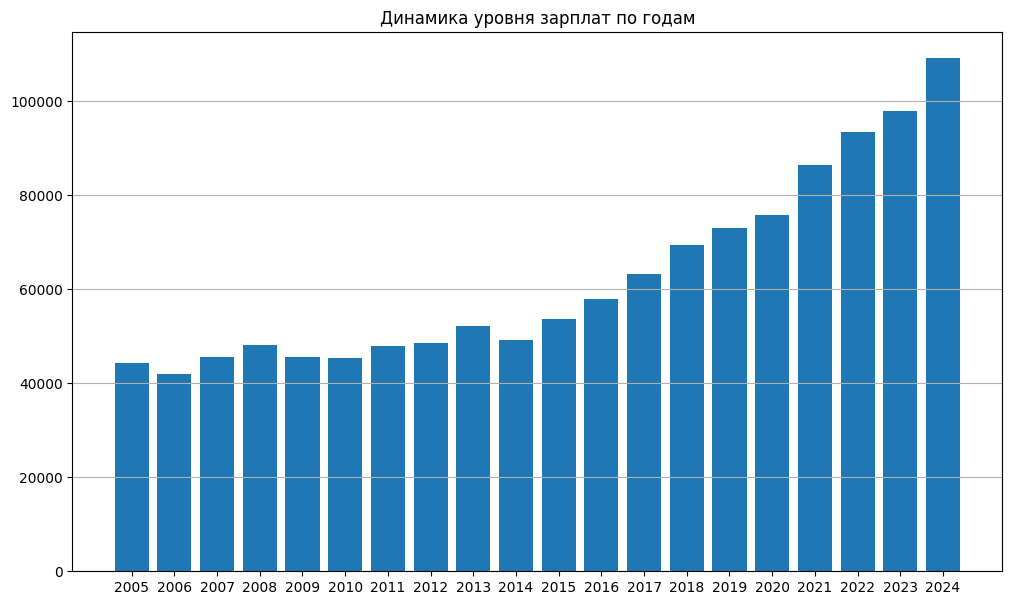

In [17]:
plt.figure(figsize=(12, 7))
plt.title("Динамика уровня зарплат по годам")
plt.bar(df_full_salary_pivot['year'],df_full_salary_pivot['avg_salary'])
plt.xticks(df_full_salary_pivot['year'])
plt.grid(axis='y')
plt.show()

### Динамика количества вакансий по годам

In [18]:
df_full_count_pivot = df_full_salary.pivot_table(index='year', values=['name'], aggfunc='count')
df_full_count_pivot = df_full_count_pivot.reset_index()

df_res = df_full_count_pivot.copy()

df1 = df_res.iloc[len(df_res)//2:][::-1]
df2 = df_res.iloc[:len(df_res)//2][::-1]

df_combined = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)
df_combined.columns = ['year_1', 'name1', 'year_2', 'name2']
df_combined.set_index('year_1', inplace=True)
df_combined

,name1,year_2,name2
year_1,,,
2024,95477,2014,75826
2023,144920,2013,68149
2022,209473,2012,49309
2021,212989,2011,42282
2020,141761,2010,31930
2019,127986,2009,20989
2018,146452,2008,30627
2017,93640,2007,24000
2016,84804,2006,16229


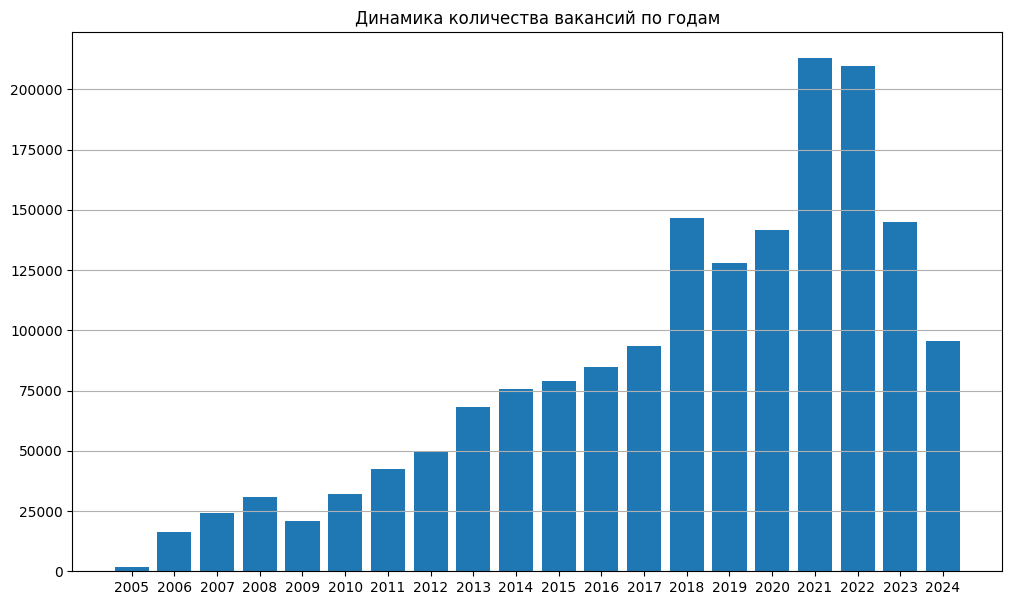

In [19]:
plt.figure(figsize=(12, 7))
plt.bar(df_full_count_pivot['year'],df_full_count_pivot['name'])

plt.xticks(df_full_count_pivot['year'])
plt.title("Динамика количества вакансий по годам")
plt.grid(axis='y')
plt.show()

### Уровень зарплат по городам

In [20]:
df_full_salary_level = df_full.pivot_table(index='area_name', values=['avg_salary', 'name'], aggfunc={'avg_salary':'mean', 'name':'count'}).reset_index().sort_values(by=["name",'avg_salary'], ascending=False).head(16)

df_res = df_full_salary_level.copy()
df_res['avg_salary'] = df_res['avg_salary'].astype(int)
df1 = df_res.iloc[len(df_res)//2:][::-1]
df2 = df_res.iloc[:len(df_res)//2]

df_combined = pd.concat([df2.reset_index(drop=True), df1.reset_index(drop=True)], axis=1)
df_combined.columns = ['town1', 'avg_salary1', 'count1', 'town2', 'avg_salary2', 'count2']
df_combined.set_index('town1', inplace=True)
df_combined[['avg_salary1', 'town2', 'avg_salary2']]

,avg_salary1,town2,avg_salary2
town1,,,
Москва,95090,Челябинск,62068
Санкт-Петербург,81911,Пермь,58834
Новосибирск,80134,Минск,87345
Казань,67751,Уфа,61522
Екатеринбург,76822,Красноярск,59397
Алматы,55242,Воронеж,57274
Нижний Новгород,63659,Самара,63211
Краснодар,64967,Ростов-на-Дону,57074


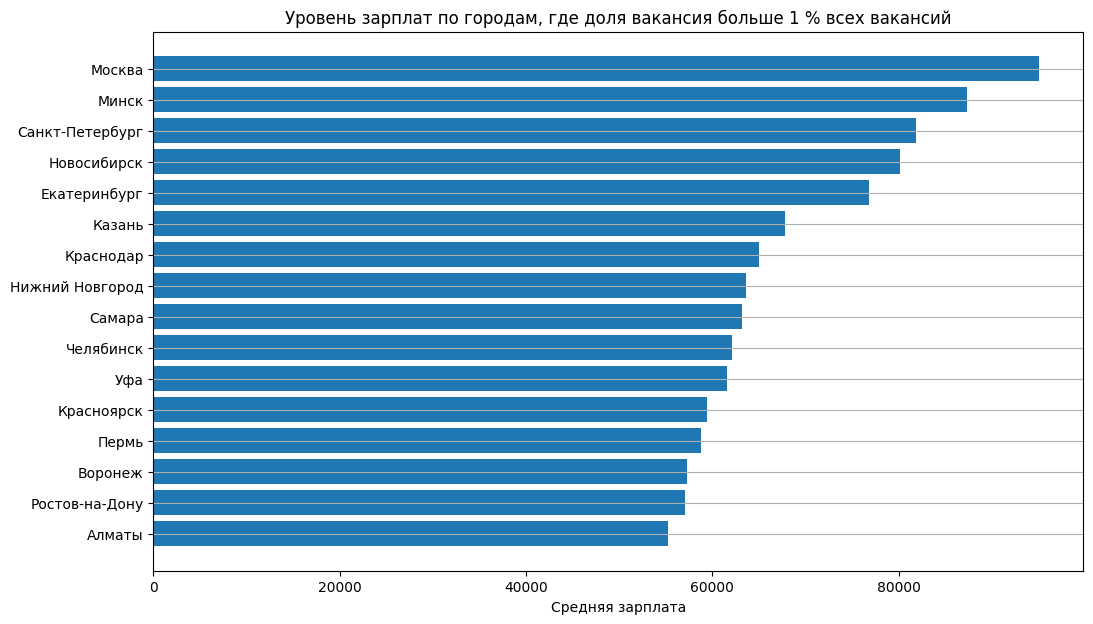

In [21]:
df_full_salary_level = df_full_salary_level.sort_values(by='avg_salary', ascending=True)
plt.figure(figsize=(12,7))
plt.barh(df_full_salary_level['area_name'], df_full_salary_level['avg_salary'])
plt.title("Уровень зарплат по городам, где доля вакансия больше 1 % всех вакансий")
plt.xlabel('Средняя зарплата')
plt.grid(axis='y');

### Доля вакансий по городам

In [22]:
df_full_salary_level_all = df_full.pivot_table(index='area_name', values=['avg_salary', 'name'], aggfunc={'avg_salary':'mean', 'name':'count'}).reset_index().sort_values(by=["name",'avg_salary'], ascending=False)

In [23]:
df_full_salary_level_all

,area_name,avg_salary,name
2417,Москва,95090.904843,489977
3346,Санкт-Петербург,81911.626633,178729
2679,Новосибирск,80134.133512,42643
1470,Казань,67751.433228,37902
1134,Екатеринбург,76822.792921,37569
...,...,...,...
3105,Пригородный,900.000000,1
3376,Свердловск,182.114050,1
18,Агдаш,55.000000,1
4133,Чегем Второй,40.000000,1


In [24]:
df_full_salary_level_head = df_full_salary_level_all.head(9)
other_cities_count = df_full_salary_level_all['name'].iloc[9:].sum()
other_city = pd.DataFrame({'area_name': ['Другие'], 'name': [other_cities_count]})

final_df = pd.concat([df_full_salary_level_head, other_city], axis=0)

df_res = final_df.copy()
df_res.set_index('area_name', inplace=True)
display(df_res[['name']])

,name
area_name,
Москва,489977
Санкт-Петербург,178729
Новосибирск,42643
Казань,37902
Екатеринбург,37569
Алматы,36187
Нижний Новгород,34718
Краснодар,31748
Ростов-на-Дону,30926


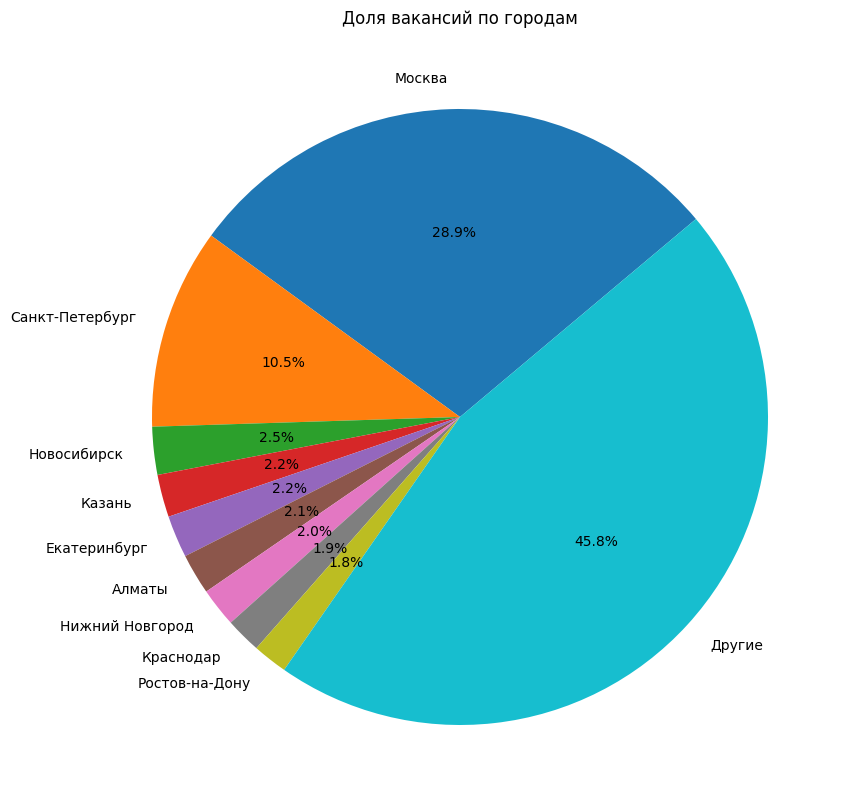

In [25]:
plt.figure(figsize=(15, 10))
plt.pie(final_df['name'], labels=final_df['area_name'], autopct='%1.1f%%', startangle=40)
plt.title("Доля вакансий по городам");

### ТОП-20 навыков по годам. Наиболее высокочастотные навыки

In [26]:
from collections import Counter
from itertools import islice
from IPython.display import display
from tabulate import tabulate

def top_skills(year):
    all_skills = df_full[(df_full['year'] == year) & (df_full['key_skills'].notna())]
    all_skills = all_skills['key_skills'].str.cat(sep='\n').split('\n')
    skill_frequency = Counter(all_skills)

    sorted_dict_desc = dict(sorted(skill_frequency.items(), key=lambda item: item[1], reverse=True))
    first_20_pairs = dict(islice(sorted_dict_desc.items(), 20))

    skills_frame = pd.DataFrame.from_dict(first_20_pairs, orient='index').reset_index()
    skills_frame.columns = ['skill', 'freq']
    skills_frame = skills_frame.sort_values(by='freq')
    df = skills_frame.copy()
    df.set_index('skill', inplace=True)
    display(df[::-1])
    plt.title(f"ТОП-20 навыков за {year} год")
    plt.barh(skills_frame['skill'], skills_frame['freq'])
    plt.xticks(rotation=45)
    plt.grid(axis='y');
    plt.show()

,freq
skill,
JavaScript,1515
HTML,1367
PHP,1349
jQuery,1213
MySQL,1171
CSS,1119
HTML5,1032
Git,1003
Ведение переговоров,926


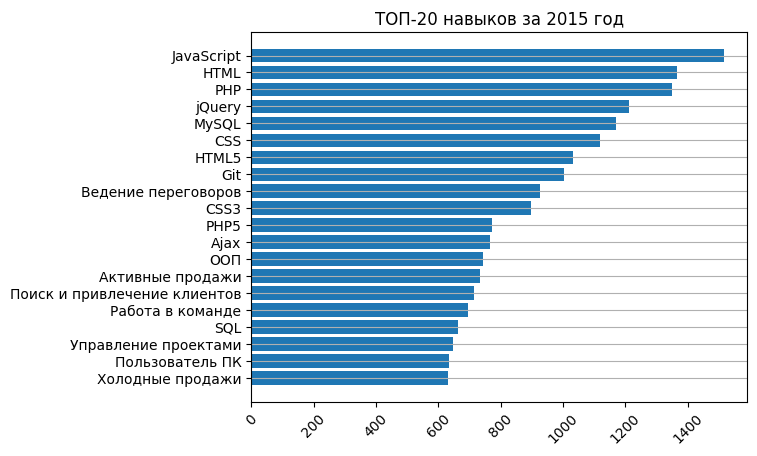

,freq
skill,
JavaScript,5409
HTML,4449
PHP,4195
CSS,3767
jQuery,3728
Git,3584
MySQL,3444
Ведение переговоров,3132
HTML5,3030


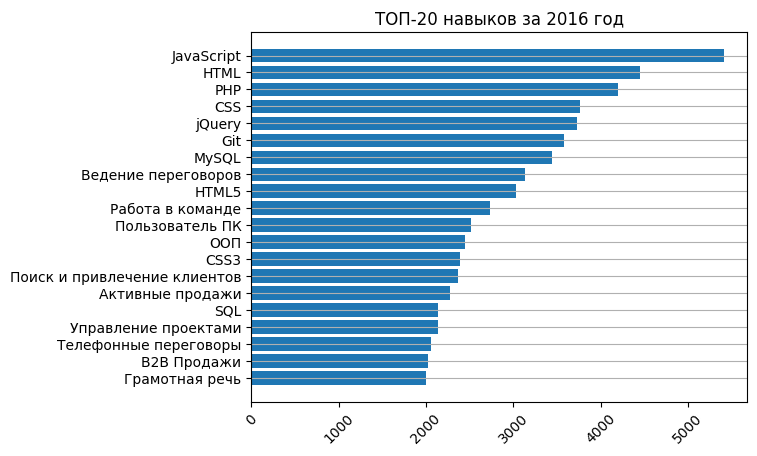

,freq
skill,
JavaScript,7237
HTML,5877
PHP,5443
CSS,5219
Git,4836
MySQL,4715
Ведение переговоров,4193
jQuery,3981
HTML5,3780


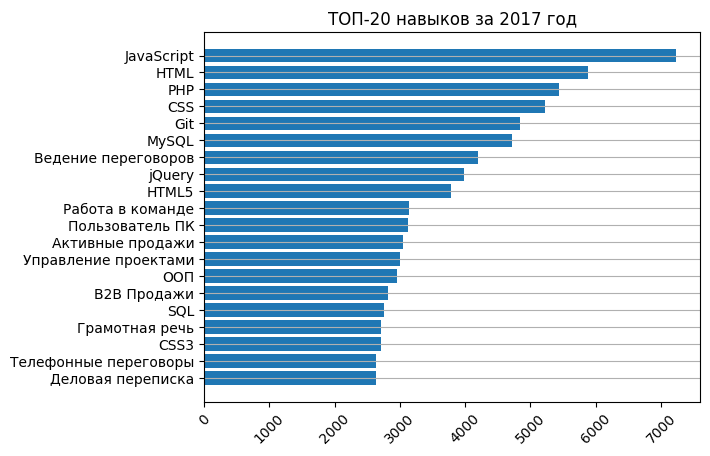

,freq
skill,
JavaScript,10438
HTML,8459
Git,7596
PHP,7451
CSS,7377
MySQL,6683
Ведение переговоров,6336
Работа в команде,5626
Пользователь ПК,5535


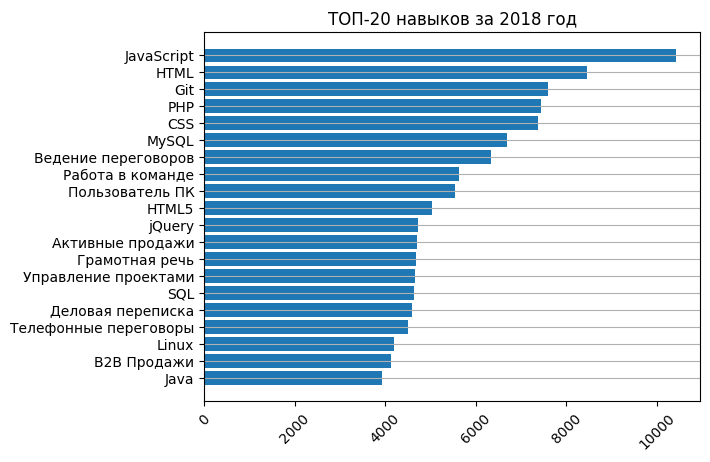

,freq
skill,
JavaScript,9719
Пользователь ПК,7773
Git,7650
HTML,7411
Работа в команде,7112
Грамотная речь,6826
Ведение переговоров,6784
CSS,6481
PHP,6361


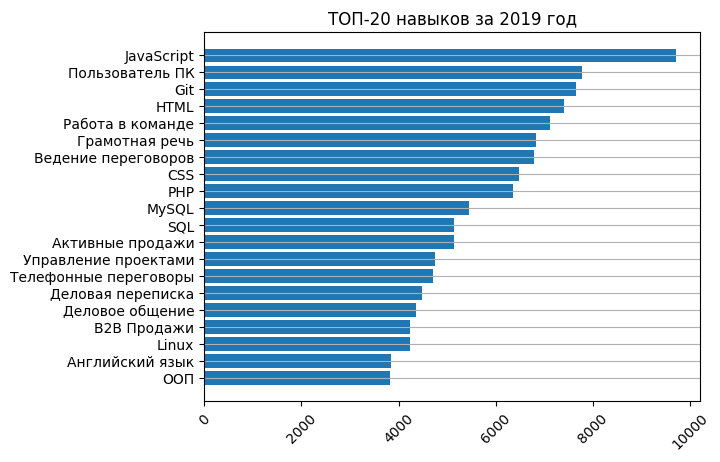

,freq
skill,
Пользователь ПК,14586
Грамотная речь,12789
Работа в команде,12276
Git,11336
JavaScript,11116
Активные продажи,9874
HTML,8430
SQL,7811
CSS,7720


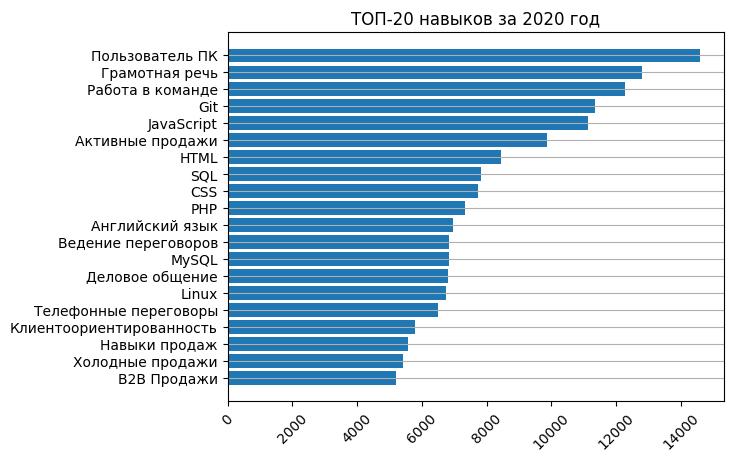

,freq
skill,
Работа в команде,29628
Грамотная речь,27798
Пользователь ПК,23415
Git,17879
JavaScript,15711
Английский язык,13905
Деловое общение,12522
SQL,12450
Активные продажи,12266


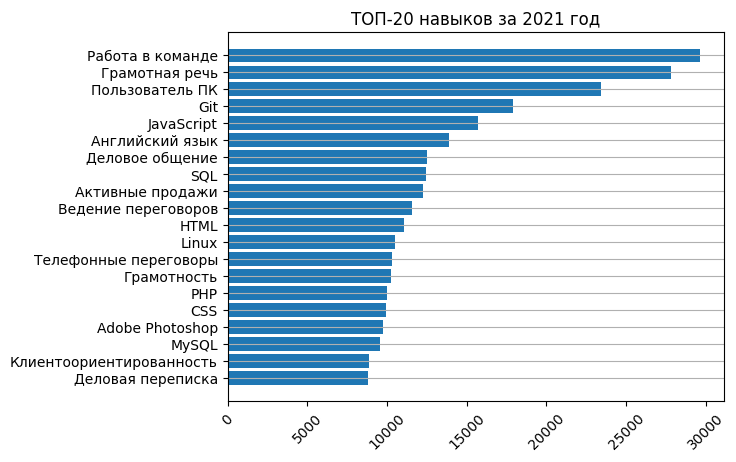

,freq
skill,
Работа в команде,29444
Пользователь ПК,20742
Грамотная речь,16508
Git,14298
JavaScript,11275
SQL,10978
Английский язык,10543
Adobe Photoshop,10084
Linux,9713


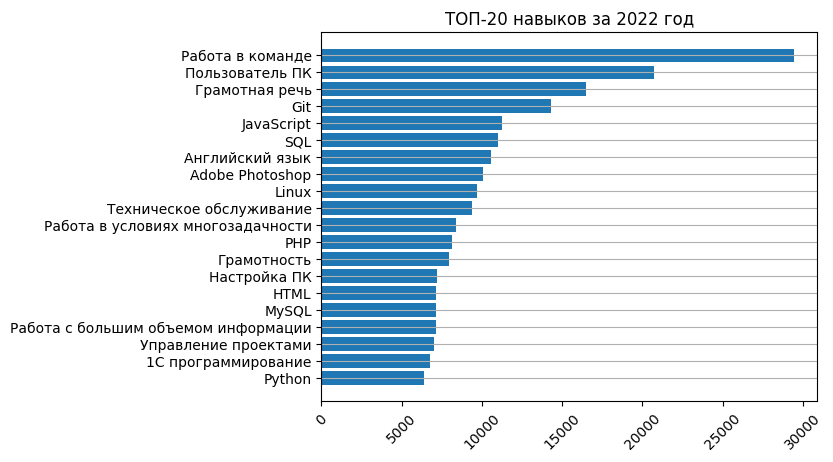

,freq
skill,
Работа в команде,12754
Грамотная речь,11326
Пользователь ПК,9976
Git,8186
Adobe Photoshop,8046
SQL,7448
JavaScript,6324
Linux,6247
Техническая поддержка,5884


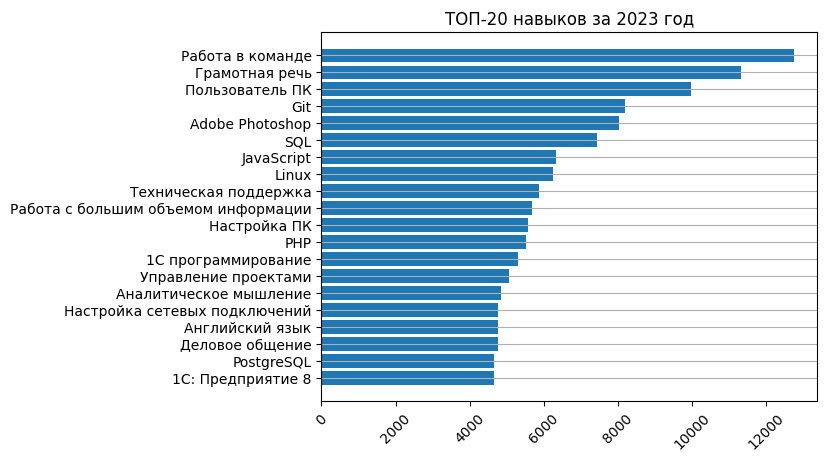

,freq
skill,
Техническая поддержка,5655
SQL,5498
Настройка ПК,4976
Adobe Photoshop,4862
Git,4607
Грамотная речь,4603
Пользователь ПК,4388
Аналитическое мышление,4343
Работа в команде,4342


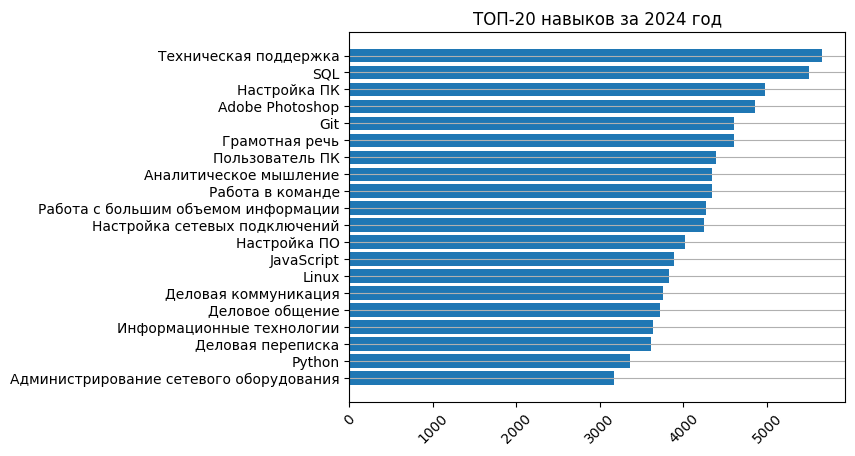

In [27]:
for i in range(2015, 2025):
  top_skills(i)

# Аналитика по профессии

In [28]:
df_copy = df.copy()

In [29]:
names = ['backend', 'бэкэнд', 'бэкенд', 'бекенд', 'бекэнд', 'back end', 'бэк энд', 'бэк енд', 'django', 'flask', 'laravel', 'yii', 'symfony']

df_copy = df_copy[df_copy['name'].str.lower().str.contains('|'.join(names))]
df_copy

,name,key_skills,salary_from,salary_to,salary_currency,area_name,published_at
71446,Программиста с навыками разработки баз (Skills...,NaN,NaN,NaN,NaN,Воронеж,2007-03-27 20:23:18+04:00
75993,Программист с навыками разработки баз (Skills ...,NaN,NaN,NaN,NaN,Воронеж,2007-05-03 12:51:29+04:00
81397,Программист с навыками разработки баз (Skills ...,NaN,NaN,NaN,NaN,Воронеж,2007-06-13 11:51:59+04:00
97640,Test Vehicle Back End Engeneer,NaN,NaN,NaN,NaN,Москва,2007-09-28 16:21:28+04:00
105723,Test Vehicle Back End Engeneer,NaN,NaN,NaN,NaN,Москва,2007-11-15 15:25:25+03:00
...,...,...,...,...,...,...,...
6915257,Python Django Разработчик,NaN,NaN,NaN,NaN,Москва,2024-11-30 11:45:37+03:00
6915258,Tech Lead Node.js (Backend разработчик/руковод...,Git\nNode.js\nTypeScript\nJavaScript\nPostgreS...,250000.0,NaN,RUR,Казань,2024-11-30 22:29:02+03:00
6915260,Tech Lead Node.js (Backend разработчик/руковод...,Git\nNode.js\nTypeScript\nJavaScript\nPostgreS...,250000.0,NaN,RUR,Екатеринбург,2024-11-30 22:29:02+03:00
6915273,Tech Lead Node.js (Backend разработчик/руковод...,Git\nNode.js\nTypeScript\nJavaScript\nPostgreS...,250000.0,NaN,RUR,Хабаровск,2024-11-30 22:29:02+03:00


In [30]:
df_copy[['salary_from','salary_to']] = df_copy[['salary_from','salary_to']].map(lambda x: float(x))

In [31]:
df_copy['data'] = df_copy['published_at'].apply(extract)

In [32]:
df_copy['avg_salary'] = df_copy.apply(avg_salary,axis=1)

In [33]:
df_copy = df_copy[df_copy['avg_salary'] < 10_000_000]
df_copy.shape

(24613, 9)

In [34]:
df_copy['year'] = df_copy['published_at'].apply(extract_year)

<ipython-input-34-a6527b758dec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['year'] = df_copy['published_at'].apply(extract_year)


In [35]:
df_copy['name'].value_counts()

,count
name,
Backend-разработчик,661
Backend разработчик,552
Backend Developer,206
Backend-разработчик (PHP),188
Backend разработчик (PHP),176
...,...
Backend разработчик PHP/Laravel (junior / middle),1
Back-end Python/Django,1
Senior/Middle darajasidagi PHP Yii2 dasturchilarni,1


In [36]:
df_copy_salary = df_copy[["name","avg_salary", "area_name",'year']].copy()

## Востребованность

### Динамика уровня зарплат по годам для выбранной профессии

In [65]:
df_copy_salary_pivot = df_copy_salary.pivot_table(index='year', values=['avg_salary'], aggfunc='mean')
df_copy_salary_pivot = df_copy_salary_pivot.reset_index()

df_res = df_copy_salary_pivot.copy()
df_res['avg_salary'] = df_res['avg_salary'].astype(int)
df1 = df_res.iloc[len(df_res)//2:][::-1]
df2 = df_res.iloc[:len(df_res)//2][::-1]

df_combined = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)
df_combined.columns = ['year_1', 'avg_salary_1', 'year_2', 'avg_salary_2']
df_combined.set_index('year_1', inplace=True)
df_combined


,avg_salary_1,year_2,avg_salary_2
year_1,,,
2024,181645,2016,86633
2023,170457,2015,80062
2022,175838,2014,66775
2021,156493,2013,66877
2020,139433,2012,69233
2019,120088,2011,56910
2018,102942,2010,56386
2017,98988,2009,60971


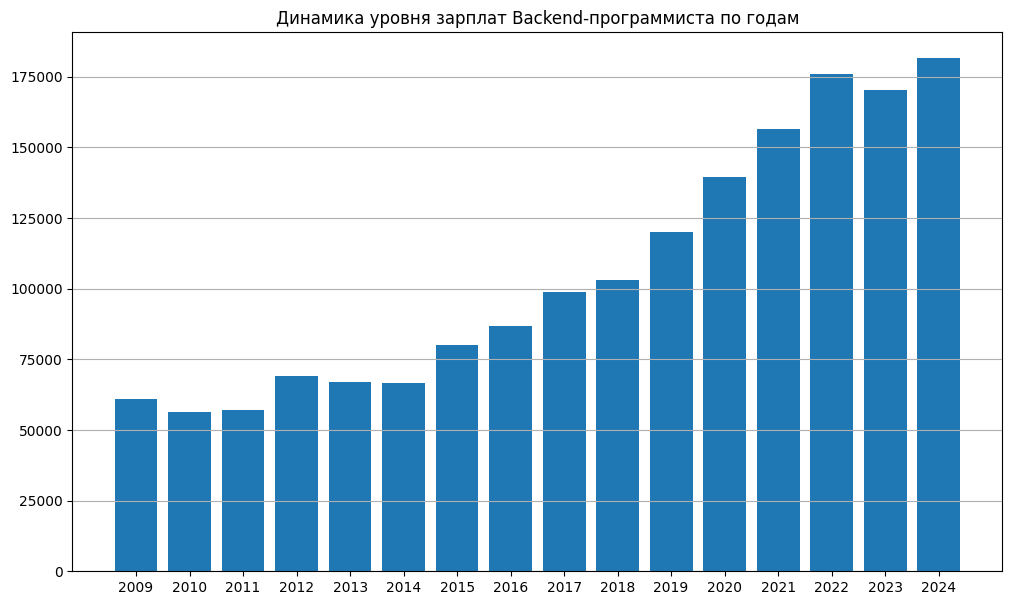

In [38]:
plt.figure(figsize=(12, 7))
plt.title("Динамика уровня зарплат Backend-программиста по годам")
plt.bar(df_copy_salary_pivot['year'],df_copy_salary_pivot['avg_salary'])
plt.xticks(df_copy_salary_pivot['year'])
plt.grid(axis='y')
plt.show()

### Динамика количества вакансий по годам для выбранной профессии

,year,count,year,count
0,2024,1898,2016,778
1,2023,3252,2015,469
2,2022,4197,2014,263
3,2021,5268,2013,177
4,2020,2865,2012,127
5,2019,2195,2011,55
6,2018,1798,2010,35
7,2017,1220,2009,16


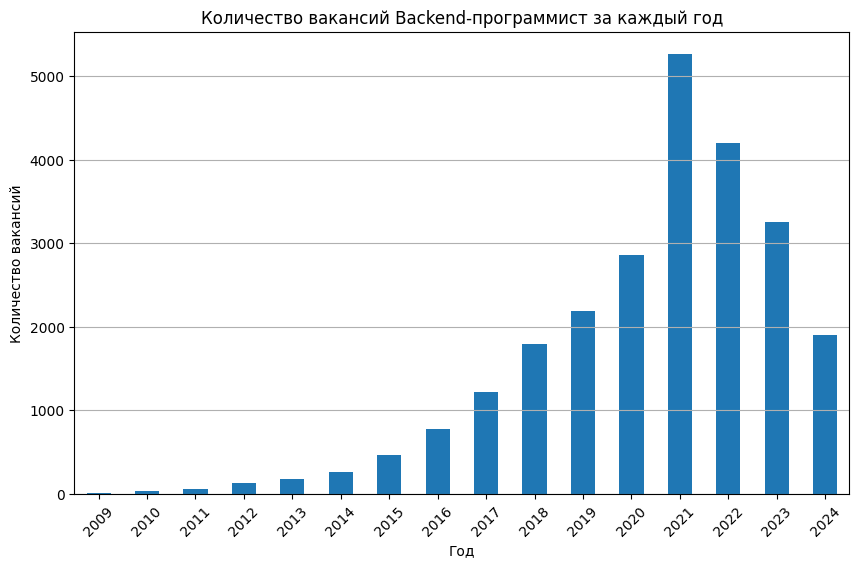

In [79]:
vacancies_per_year = df_copy['year'].value_counts().sort_index()

df_res = vacancies_per_year.copy().reset_index()
df1 = df_res.iloc[len(df_res)//2:][::-1]
df2 = df_res.iloc[:len(df_res)//2][::-1]

df_combined = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)
display(df_combined)

plt.figure(figsize=(10, 6))
vacancies_per_year.plot(kind='bar')
plt.title('Количество вакансий Backend-программист за каждый год')
plt.xlabel('Год')
plt.ylabel('Количество вакансий')
plt.xticks(rotation=45)
plt.grid(axis='y')

## География

### Горизонтальная диаграмма - уровень зарплат по городам

In [102]:
df_copy_salary_level = df_copy.pivot_table(index='area_name', values=['avg_salary', 'name'], aggfunc={'avg_salary':'mean', 'name':'count'}).reset_index().sort_values(by=["name",'avg_salary'], ascending=False).head(16)
df_copy_salary_level['avg_salary'] = df_copy_salary_level['avg_salary'].astype(int)

df_res = df_copy_salary_level.sort_values(by='avg_salary', ascending=False).copy()
df1 = df_res.iloc[len(df_res)//2:]
df2 = df_res.iloc[:len(df_res)//2]

df_combined = pd.concat([df2.reset_index(drop=True), df1.reset_index(drop=True)], axis=1)
df_combined.columns = ['town1', 'avg_salary1', 'count1', 'town2', 'avg_salary2', 'count2']
df_combined.set_index('town1', inplace=True)
df_combined[['avg_salary1', 'town2', 'avg_salary2']]


,avg_salary1,town2,avg_salary2
town1,,,
Москва,177804,Самара,134254
Киев,160009,Томск,128579
Санкт-Петербург,153312,Краснодар,120729
Казань,148694,Пермь,113352
Нижний Новгород,145745,Ростов-на-Дону,112353
Новосибирск,145323,Челябинск,107633
Минск,144115,Ташкент,105752
Екатеринбург,138191,Алматы,97775


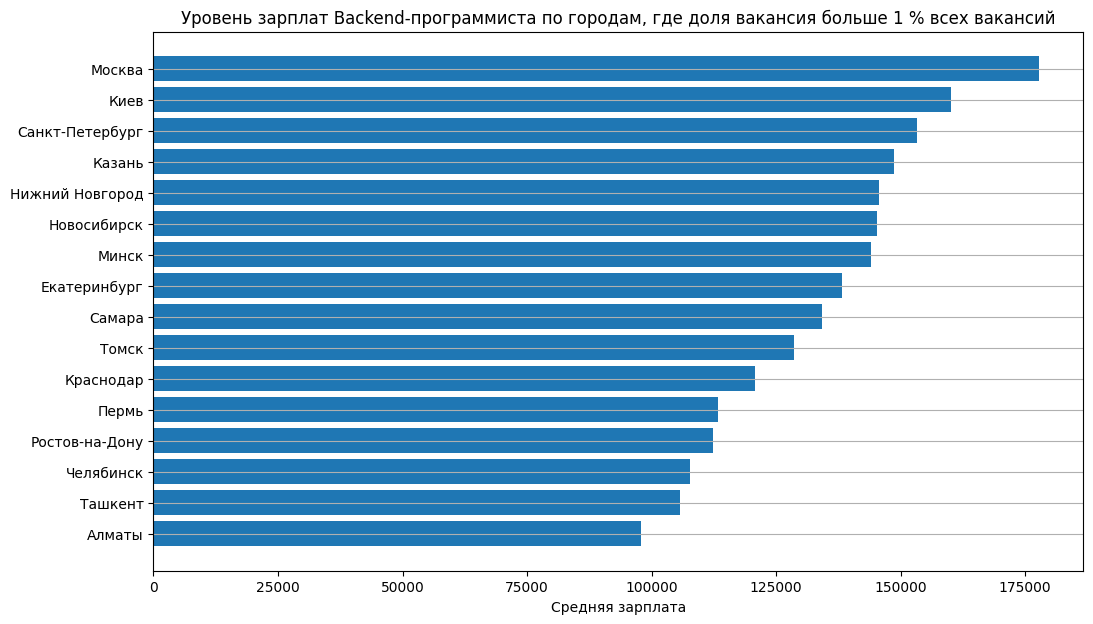

In [41]:
df_copy_salary_level = df_copy_salary_level.sort_values(by='avg_salary', ascending=True)
plt.figure(figsize=(12,7))
plt.barh(df_copy_salary_level['area_name'], df_copy_salary_level['avg_salary'])
plt.title("Уровень зарплат Backend-программиста по городам, где доля вакансия больше 1 % всех вакансий")
plt.xlabel('Средняя зарплата')
plt.grid(axis='y');

### Доля вакансий по городам для выбранной профессии (в порядке убывания)

In [42]:
df_copy_salary_level_all = df_copy.pivot_table(index='area_name', values=['avg_salary', 'name'], aggfunc={'avg_salary':'mean', 'name':'count'}).reset_index().sort_values(by=["name",'avg_salary'], ascending=False)

In [103]:
df_copy_salary_level_head = df_copy_salary_level_all.head(9)
other_cities_count = df_copy_salary_level_all['name'].iloc[9:].sum()
other_city = pd.DataFrame({'area_name': ['Другие'], 'name': [other_cities_count]})

final_df = pd.concat([df_copy_salary_level_head, other_city], axis=0)

final_df[['area_name', 'name']]

,area_name,name
177,Москва,7921
243,Санкт-Петербург,3165
197,Новосибирск,890
8,Алматы,846
92,Екатеринбург,837
111,Казань,598
143,Краснодар,537
174,Минск,487
275,Ташкент,450
0,Другие,8882


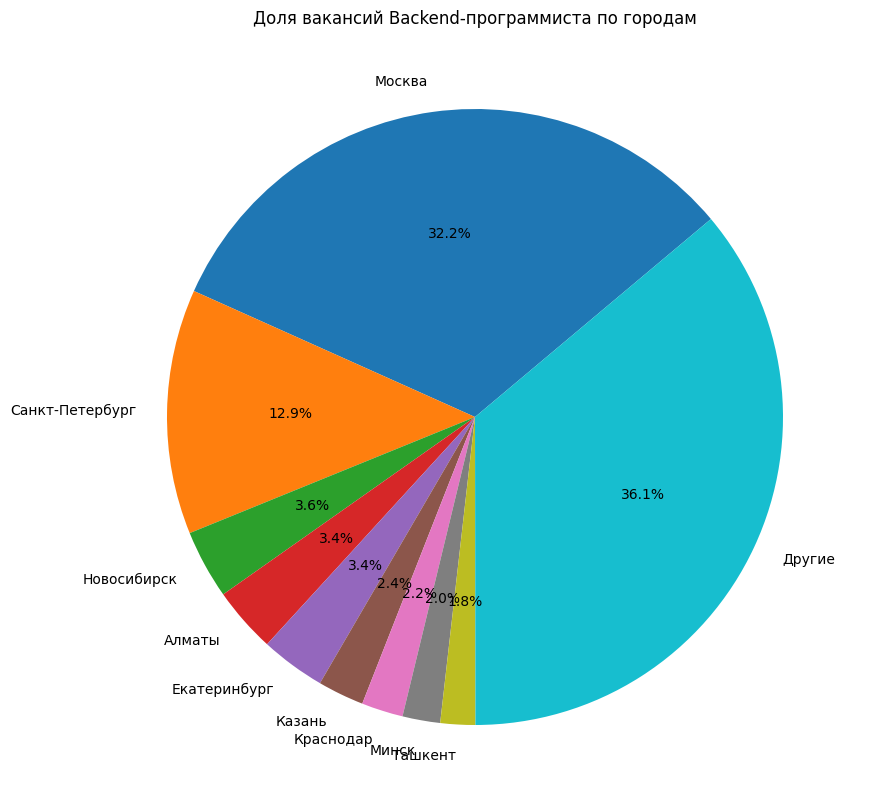

In [44]:
plt.figure(figsize=(15, 10))
plt.pie(final_df['name'], labels=final_df['area_name'], autopct='%1.1f%%', startangle=40)
plt.title("Доля вакансий Backend-программиста по городам");

## Навыки

### ТОП-20 навыков по годам для выбранной профессии. Наиболее высокочастотные навыки (по анализу поля: key_skills).

In [45]:
from collections import Counter
all_skills = df_copy[df_copy['key_skills'].notna()]
all_skills = df_copy['key_skills'].str.cat(sep='\n').split('\n')
skill_frequency = Counter(all_skills)

In [46]:
sorted_dict_desc = dict(sorted(skill_frequency.items(), key=lambda item: item[1], reverse=True))

In [122]:
from itertools import islice
def top_skills_back(year):
    all_skills = df_copy[(df_copy['year'] == year) & (df_copy['key_skills'].notna())]
    all_skills = all_skills['key_skills'].str.cat(sep='\n').split('\n')
    skill_frequency = Counter(all_skills)

    sorted_dict_desc = dict(sorted(skill_frequency.items(), key=lambda item: item[1], reverse=True))
    first_20_pairs = dict(islice(sorted_dict_desc.items(), 20))

    skills_frame = pd.DataFrame.from_dict(first_20_pairs, orient='index').reset_index()
    skills_frame.columns = ['skill', 'freq']
    skills_frame = skills_frame.sort_values(by='freq')

    df_res = skills_frame.copy()
    df1 = df_res.iloc[len(df_res)//2:]
    df2 = df_res.iloc[:len(df_res)//2]

    df_combined = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)
    df_combined.columns = ['Навык1', 'Кол-во1', 'Навык2', 'Кол-во2']
    df_combined.set_index('Навык1', inplace=True)
    display(df_combined[::-1])

    plt.title(f"ТОП-20 навыков для Backend-программиста за {year}")
    plt.barh(skills_frame['skill'], skills_frame['freq'])
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()


,Кол-во1,Навык2,Кол-во2
Навык1,,,
MySQL,56,HTML,25
Git,53,Yii,23
PHP5,38,CSS,21
JavaScript,38,CSS3,19
PHP,36,Bootstrap,19
Python,35,PostgreSQL,16
ООП,32,HTML5,15
Linux,31,1С-Битрикс,15
Django Framework,29,Node.js,14


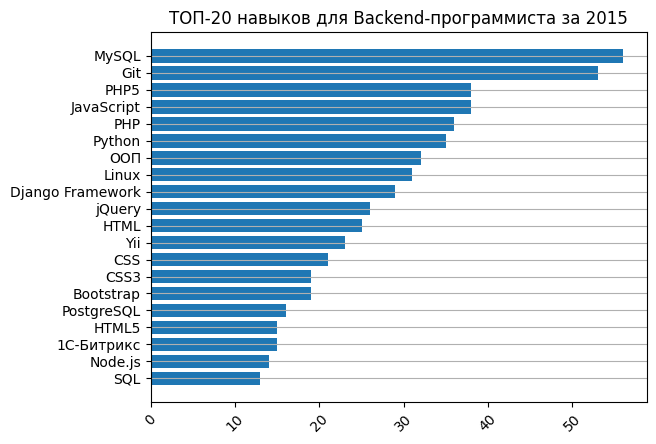

,Кол-во1,Навык2,Кол-во2
Навык1,,,
PHP,197,SQL,94
MySQL,196,PHP5,85
Git,191,PostgreSQL,80
JavaScript,171,Django Framework,74
Yii,136,CSS3,73
jQuery,122,CSS,70
Python,114,Bootstrap,66
ООП,107,HTML,64
Linux,107,Ajax,54


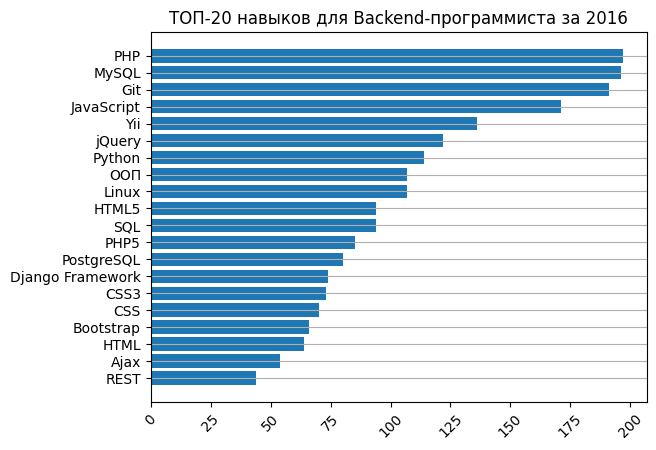

,Кол-во1,Навык2,Кол-во2
Навык1,,,
Git,426,CSS,175
PHP,386,SQL,171
MySQL,365,Django Framework,163
JavaScript,346,Yii,151
ООП,258,PHP5,140
Python,231,HTML5,137
PostgreSQL,210,Ajax,93
Linux,209,Bootstrap,90
jQuery,188,MVC,87


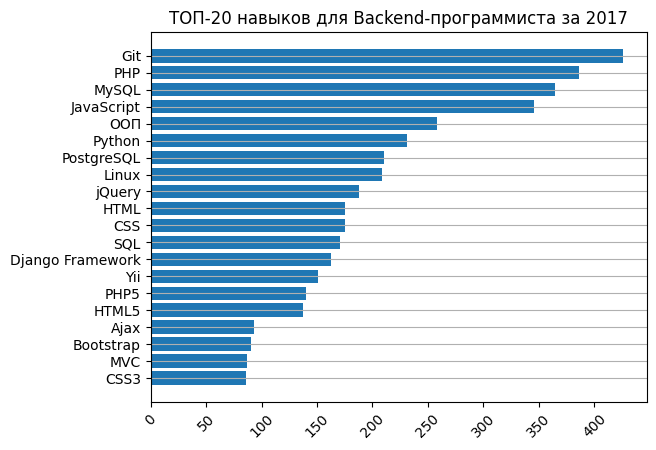

,Кол-во1,Навык2,Кол-во2
Навык1,,,
PHP,649,Python,260
Git,613,Linux,252
MySQL,605,HTML5,233
JavaScript,440,Yii,221
PostgreSQL,414,Django Framework,197
ООП,336,PHP5,184
SQL,330,Ajax,180
HTML,317,Bootstrap,143
CSS,277,Symfony,128


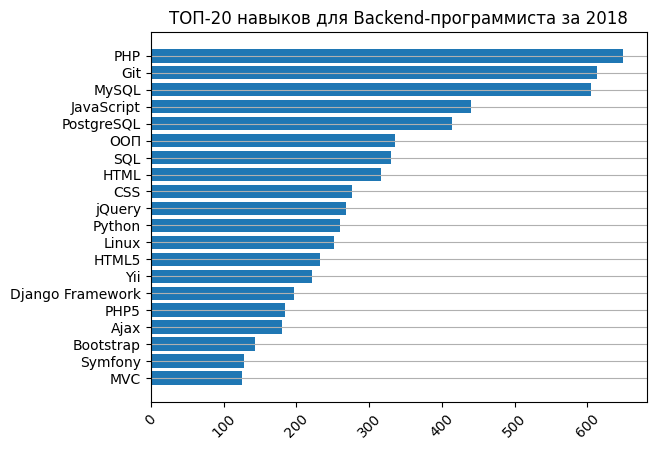

,Кол-во1,Навык2,Кол-во2
Навык1,,,
Git,866,Python,301
PHP,859,Yii,259
MySQL,689,Node.js,249
JavaScript,620,jQuery,242
PostgreSQL,483,HTML5,225
ООП,443,Symfony,213
Linux,388,PHP5,206
SQL,380,Laravel,199
CSS,311,Django Framework,193


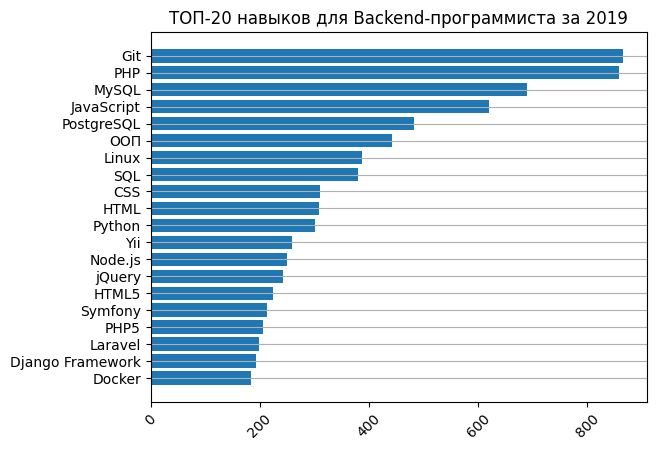

,Кол-во1,Навык2,Кол-во2
Навык1,,,
Git,1538,HTML,398
PHP,1217,CSS,392
MySQL,1129,Laravel,356
PostgreSQL,829,Django Framework,309
JavaScript,790,MongoDB,303
ООП,659,Yii,298
SQL,643,Symfony,281
Linux,552,jQuery,278
Python,506,PHP5,254


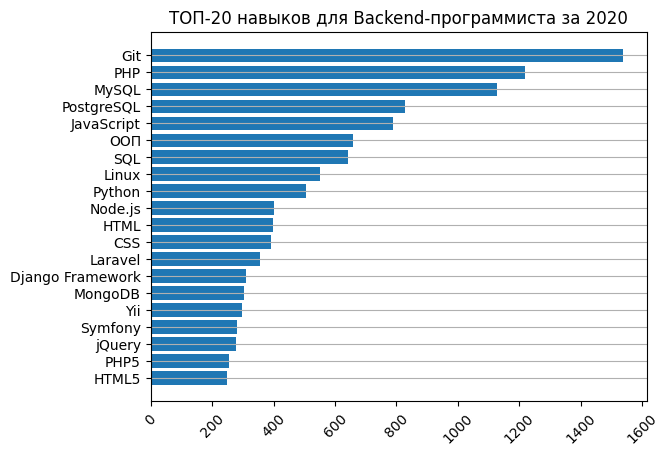

,Кол-во1,Навык2,Кол-во2
Навык1,,,
Git,2619,Django Framework,692
PHP,2109,Docker,674
MySQL,1842,HTML,668
PostgreSQL,1542,Node.js,626
JavaScript,1287,CSS,624
ООП,1109,Redis,586
SQL,1094,Symfony,574
Python,1083,REST,441
Linux,976,MongoDB,398


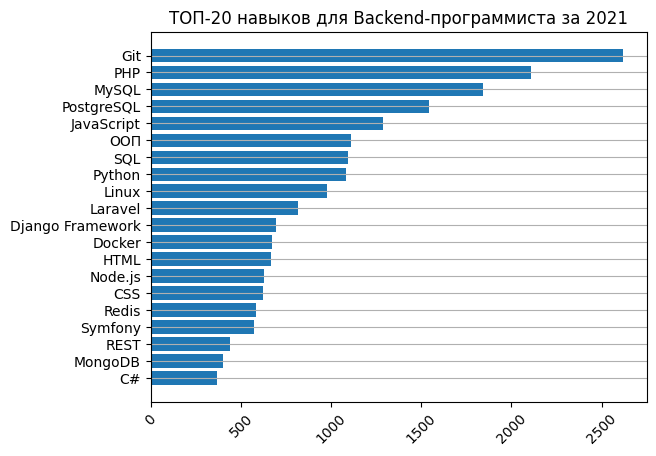

,Кол-во1,Навык2,Кол-во2
Навык1,,,
Git,2205,Linux,702
PHP,1867,Redis,541
MySQL,1624,Node.js,525
PostgreSQL,1291,HTML,453
ООП,1045,Django Framework,416
SQL,981,Symfony,403
JavaScript,928,CSS,379
Laravel,795,API,355
Python,779,MongoDB,332


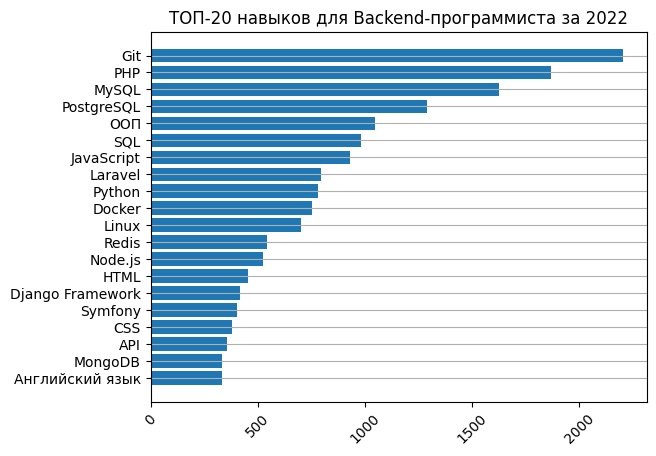

,Кол-во1,Навык2,Кол-во2
Навык1,,,
PHP,1432,Linux,420
Git,1429,Redis,370
PostgreSQL,1062,HTML,357
MySQL,984,Node.js,356
Laravel,767,Backend,316
ООП,682,CSS,311
JavaScript,681,RabbitMQ,308
Docker,674,API,296
SQL,603,MongoDB,265


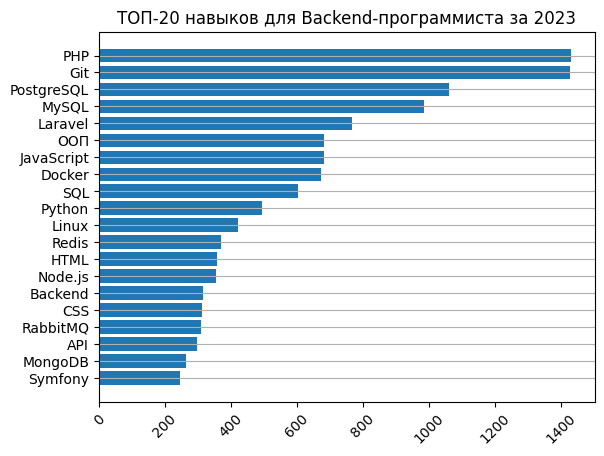

,Кол-во1,Навык2,Кол-во2
Навык1,,,
PHP,690,Linux,273
Git,672,Node.js,251
PostgreSQL,667,API,233
MySQL,500,ООП,209
Docker,469,REST API,183
Laravel,424,REST,180
JavaScript,410,RabbitMQ,179
Python,377,HTML,176
SQL,376,MongoDB,159


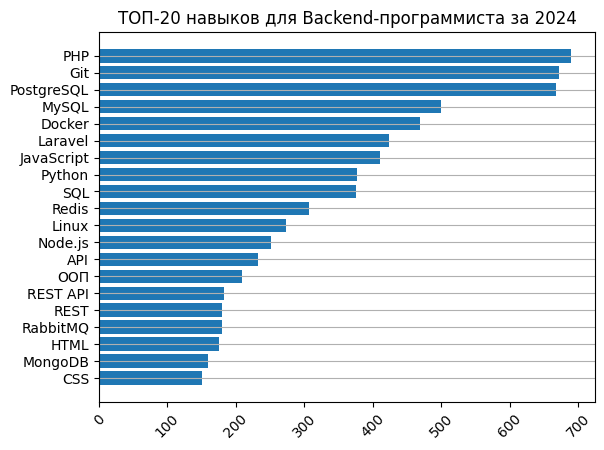

In [123]:
for i in range(2015, 2025):
  top_skills_back(i)